In [1]:
from pathlib import Path

import torch
import torch.nn.functional as F
import datasets as hfds

import olmo
from olmo.config import TrainConfig
from olmo.util import clean_opt
from olmo.torch_util import seed_all
from olmo.data import build_train_dataloader, IterableDataset

from olmo.optim import build_optimizer
from olmo.config import TrainConfig
from olmo.checkpoint import load_state_dict
from olmo.model import OLMo

from zsl_config import ZSL_DIR_OUT_OLMO, ZSL_DIR_ANALYSIS, ZSL_DIR_DATA

from typing import Union, Optional

In [2]:
MODEL_CLASS = 'olmo'
DATASET = 'c4_en_val'
ANALYSIS_NAME = 'per_token_losses'

RUNS = [
        '1028-rmsnorm-14m',
        '1028-rmsnorm-37m',
        '1028-rmsnorm-78m',
        '1028-rmsnorm-144m',
        '1028-rmsnorm-285m',
        '1028-rmsnorm-472m',
    ]

VERBOSE = True
OVERWRITE = False

OUT_DIR = ZSL_DIR_ANALYSIS / ANALYSIS_NAME
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Measure losses

## Utils

### Dataloader loading

In [3]:
tokenized_eval_data = ZSL_DIR_DATA / f'tokenized/{MODEL_CLASS}-{DATASET}'
assert tokenized_eval_data.exists()

def get_dataloader(bsz: int = 4, device: str = 'cpu'):
    dataset = hfds.load_from_disk(tokenized_eval_data)
    dataset.set_format(type='torch', columns=['input_ids'])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bsz, shuffle=False, 
                                             pin_memory=device != 'cpu', 
                                             pin_memory_device=device)
    return dataloader

if VERBOSE:
    dataloader = get_dataloader(device='cuda' if torch.cuda.is_available() else 'cpu')
    print(f"len(dataloader): {len(dataloader)}")
    print(f"batch shape: {next(iter(dataloader))['input_ids'].shape}")
    print(f"batch device: {next(iter(dataloader))['input_ids'].device}")
    del dataloader

len(dataloader): 244
batch shape: torch.Size([4, 1024])
batch device: cpu


/home/mila/m/mirceara/1.workspace/zsl/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:594: UserWarning: pin memory device is set and pin_memory flag is not used then device pinned memory won't be usedplease set pin_memory to true, if you need to use the device pin memory
  warnings.warn(warn_msg)


### Model loading

In [4]:
def load_model(run: str, step: int, device="cuda", overrides: Optional[list] = None):
    ckpt_dir = ZSL_DIR_OUT_OLMO / run / f"step{step}-unsharded"
    overrides = overrides or []
    overrides.append(f"model.init_device={device}")
    cfg = TrainConfig.load(
        ckpt_dir / "config.yaml", validate_paths=False, overrides=overrides
    )
    model = OLMo(cfg.model, init_params=False)
    state_dict = load_state_dict(ckpt_dir, "model.pt", map_location=device)
    model.load_state_dict(state_dict)
    return model


def get_model_steps(run: str):
    ckpts_dir = ZSL_DIR_OUT_OLMO / run
    return sorted(
        [
            int(d.name.replace("step", "").replace("-unsharded", ""))
            for d in ckpts_dir.glob("step[1-9]*-unsharded")
        ]
    )

if VERBOSE:
    run = RUNS[0]
    steps = get_model_steps(run)
    print(f'steps for run {run}: {steps}')
    step = steps[5]

    print("="*20, "MODEL", "="*20)
    model = load_model(run, step, device='cuda' if torch.cuda.is_available() else 'cpu')
    print(model)

    print("="*20, "PARAMS", "="*20)
    for n,p in model.named_parameters():
        print("Param: ", n, p.shape, p.dtype, p.device)
        print('.'*80)
        
    del run, step, steps, model, n, p

steps for run 1028-rmsnorm-14m: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
==================== MODEL ====================
OLMo(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 256)
    (emb_drop): Dropout(p=0.0, inplace=False)
    (ln_f): RMSLayerNorm()
    (blocks): ModuleList(
      (0-3): 4 x OLMoSequentialBlock(
        (dropout): Dropout(p=0.0, inplace=False)
        (act): SwiGLU()
        (attn_out): Linear(in_features=256, out_features=256, bias=False)
        (ff_out): Linear(in_features=128, out_features=256, bias=False)
        (rotary_emb): RotaryEmbedding()
        (att_proj): Linear(in_features=256, out_features=768, bias=False)
        (ff_proj): Linear(in_features=256, out_features=256, bias=False)
        (attn_norm): RMSLayerNorm()
        (ff_norm): RMSLayerNorm()
      )
    )
  )
)
==================== PARAMS ====================
Param:  transformer.wte.weight torch.Size([50304, 256]) torch.float32

/home/mila/m/mirceara/1.workspace/zsl/pretraining/olmo/olmo/checkpoint.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=map_locatio

## Experiment

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
overrides = ['model.flash_attention=False'] if device == 'cpu' else []

bsz = 64
dataloader = get_dataloader(bsz=bsz, device=device)

tokens = [b['input_ids'].cpu() for b in dataloader]
tokens = torch.cat(tokens, dim=0)
torch.save(tokens, OUT_DIR / f"tokens.pt")

for run in RUNS:
    out_dir = OUT_DIR / run 
    out_dir.mkdir(exist_ok=True, parents=False)
    steps = get_model_steps(run)
    for step in steps:
        out_path = out_dir / f"step{step}.pt"
        if out_path.exists() and not OVERWRITE:
            print(f"[run={run}][step={step}] Skipping {out_path} as it already exists", end='\r')
            continue    
        model = load_model(run, step, overrides=overrides, device=device).to(torch.bfloat16)

        losses = []
        with torch.inference_mode(), torch.amp.autocast(device, dtype=torch.bfloat16):
            for i, batch in enumerate(dataloader):
                print(f"[run={run}][step={step}][batch={i}] Running forward pass...", end='\r')
                batch = batch['input_ids'].to(device)
                input_ids = batch[:,:-1].contiguous()
                labels = batch[:,1:].flatten().to(device)
                logits = model(input_ids).logits.flatten(0,1)
                losses += [F.cross_entropy(logits, labels, reduction='none').cpu()]
        
        losses = torch.cat(losses, dim=0)
        torch.save(losses, out_path)


# Visualization

In [6]:
import torch
import numpy as np

from zsl_utils.mpl import *
FIG_DIR = Path.cwd() / 'fig/loss_intrf_dt=t'
FIG_DIR.mkdir(exist_ok=True, parents=True)

get_fp = lambda n: FIG_DIR / n

In [7]:
def load_losses(run, step, device='cpu'):
    f = OUT_DIR / run / f"step{step}.pt"
    losses = torch.load(f, map_location=device)
    return losses

def get_steps(run):
    d = OUT_DIR / run
    steps = [int(f.stem.split('step')[1]) for f in d.glob('*.pt')]
    steps = list(sorted(steps))
    return steps

## Loss

/tmp/ipykernel_4138575/1847538613.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = torch.load(f, map_location=device)


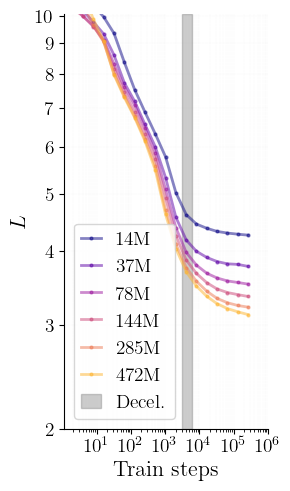

In [8]:
def plot_data(ax, run, model_size):
    steps = get_steps(run)
    color = get_color(RUNS.index(run), vmax=len(RUNS))

    losses_avg = []
    losses_std = []
    for step in steps:
        print(f"Loading {run} step {step}", end='\r')
        
        losses = load_losses(run, step)
        avg = losses.mean().item()
        std = losses.std().item()
        losses_avg += [avg]
        losses_std += [std]
    
    ax.plot(steps, losses_avg, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    return ax
    
def format_plot(fig, ax):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ylabel = '$L$'
    ax.set_ylabel(ylabel)
    ax.set_yscale('log')
    ax.yaxis.set_ticks(list(range(2,11)))
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_ylim(2, 10.1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=14, loc='lower left')

    fig.set_size_inches(*FIGSIZE_NARROW)
    plt.close(fig)
    fig.subplots_adjust(left=0.22, right=0.9, top=0.95, bottom=0.12)
    return fig, ax


fig, ax = plt.subplots()
for i, run in enumerate(RUNS):
    model_size = run.split('-')[-1].replace('m', 'M')
    ax = plot_data(ax, run, model_size)
fig, ax = format_plot(fig, ax)
display(fig)

## Destructive interference

/tmp/ipykernel_4138575/1847538613.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = torch.load(f, map_location=device)


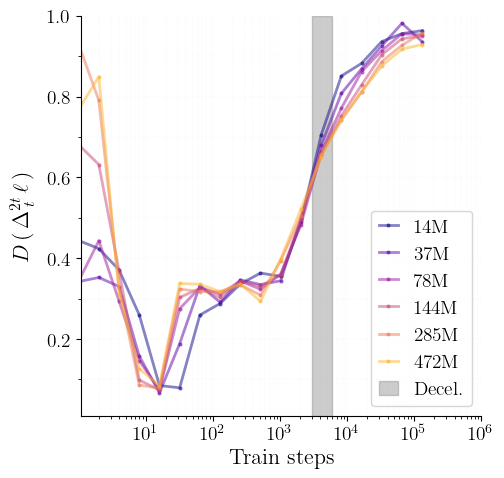

In [9]:
fig_path = get_fp('D.pdf')

def plot_data(ax, run, model_size):
    steps = get_steps(run)
    color = get_color(RUNS.index(run), vmax=len(RUNS))

    ldis = []
    for step1, step2 in zip(steps, steps[1:]):
        print(f"Loading {run} step {step1}", end='\r')
        
        losses1 = load_losses(run, step1)
        losses2 = load_losses(run, step2)
        dl = losses2 - losses1
        ldis.append(1-dl.sum().abs().item()/dl.abs().sum().item())
    
    ax.plot(steps[:-1], ldis, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    return ax
    
def format_plot(fig, ax):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ylabel = '$D\,(\,\Delta_{\:t}^{2t} \, \ell\,)$'
    ax.set_ylabel(ylabel)
    ax.set_yscale('linear')
    ax.set_ylim(0.01, 1)
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.labelpad = 10

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=14)

    fig.set_size_inches(5,5)
    plt.close(fig)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax


fig, ax = plt.subplots()
for i, run in enumerate(RUNS):
    model_size = run.split('-')[-1].replace('m', 'M')
    ax = plot_data(ax, run, model_size)
fig, ax = format_plot(fig, ax)
save_figure(fig, fig_path, save_json=False, save_png=False)
display(fig)

## Average Magnitude

/tmp/ipykernel_4138575/1847538613.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = torch.load(f, map_location=device)


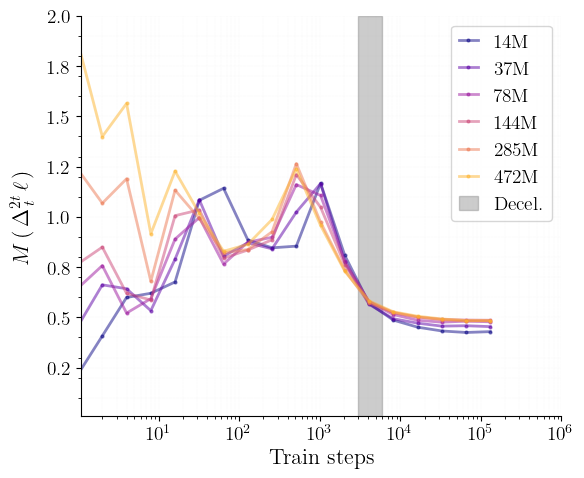

In [10]:
fig_path = get_fp('M.pdf')

def plot_data(ax, run, model_size):
    steps = get_steps(run)
    color = get_color(RUNS.index(run), vmax=len(RUNS))

    lmas = []
    for step1, step2 in zip(steps, steps[1:]):
        print(f"Loading {run} step {step1}", end='\r')
        
        losses1 = load_losses(run, step1)
        losses2 = load_losses(run, step2)
        dl = losses2 - losses1
        lmas.append(dl.abs().mean().item()) 
    
    ax.plot(steps[:-1], lmas, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    return ax

    
def format_plot(fig, ax):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ylabel = '$M\,(\,\Delta_{\:t}^{2t} \, \ell\,)$'
    ax.set_ylabel(ylabel)
    ax.set_yscale('linear')
    ax.set_ylim(0.01, 2)
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "{:.1f}".format(x)))
    ax.yaxis.labelpad = 10

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=14)

    fig.set_size_inches(*FIGSIZE_MED)
    plt.close(fig)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax



fig, ax = plt.subplots()
for i, run in enumerate(RUNS):
    model_size = run.split('-')[-1].replace('m', 'M')
    ax = plot_data(ax, run, model_size)
fig, ax = format_plot(fig, ax)
save_figure(fig, fig_path, save_json=False, save_png=False)
display(fig)

## Overall Loss Improvement (LI)

/tmp/ipykernel_4138575/1847538613.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = torch.load(f, map_location=device)


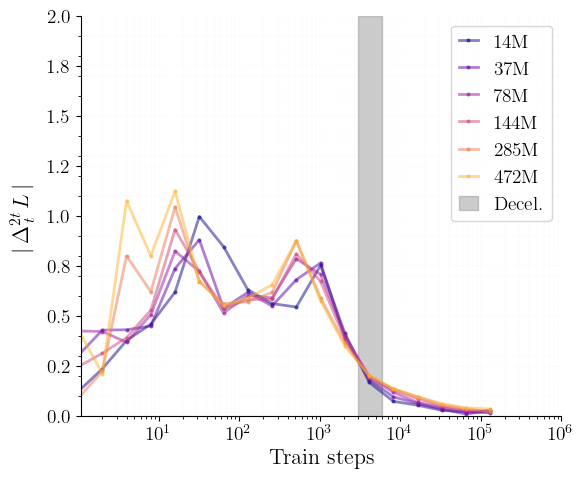

In [11]:
fig_path = get_fp('|ΔL|.pdf')

def plot_data(ax, run, model_size):
    steps = get_steps(run)
    color = get_color(RUNS.index(run), vmax=len(RUNS))

    lmas = []
    for step1, step2 in zip(steps, steps[1:]):
        print(f"Loading {run} step {step1}", end='\r')
        
        losses1 = load_losses(run, step1)
        losses2 = load_losses(run, step2)
        dl = losses2 - losses1
        lmas.append(dl.mean().abs().item()) 
    
    ax.plot(steps[:-1], lmas, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    return ax

def format_plot(fig, ax):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ylabel = '$|\,\Delta_{\:t}^{2t} \, L\,|$'
    ax.set_ylabel(ylabel)
    ax.set_yscale('linear')
    ax.set_ylim(0, 2)
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "{:.1f}".format(x)))
    ax.yaxis.labelpad = 10

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=14)

    fig.set_size_inches(*FIGSIZE_MED)
    plt.close(fig)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax



fig, ax = plt.subplots()
for i, run in enumerate(RUNS):
    model_size = run.split('-')[-1].replace('m', 'M')
    ax = plot_data(ax, run, model_size)
fig, ax = format_plot(fig, ax)
save_figure(fig, fig_path, save_json=False, save_png=False)
display(fig)

## Training Trajectories in DI/MA/LD

/tmp/ipykernel_4138575/1847538613.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = torch.load(f, map_location=device)


/tmp/ipykernel_4138575/279471552.py:49: RuntimeWarning: divide by zero encountered in log2
  Z = np.log2((1-X)*Y).clip(min=-7, max=1)


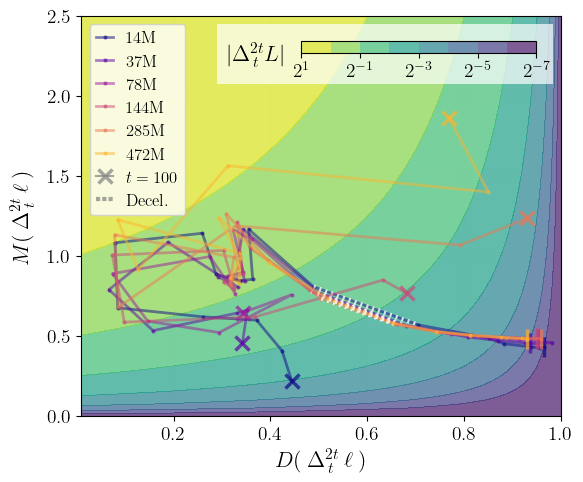

In [13]:
fig_path = get_fp('D_vs_M.pdf')

def plot_data(ax, run, model_size, decel_span=[3000,6000], min_step=0):
    steps = get_steps(run)
    steps = [step for step in steps if step >= min_step]
    color = get_color(RUNS.index(run), vmax=len(RUNS))

    ldis = []
    mags = []
    ldi_decel = []
    mag_decel = []
    for step1, step2 in zip(steps, steps[1:]):
        print(f"Loading {run} step {step1}", end='\r')
        
        losses1 = load_losses(run, step1)
        losses2 = load_losses(run, step2)
        dl = losses2 - losses1
        ldis.append(1-dl.sum().abs().item()/dl.abs().sum().item())
        mags.append(dl.abs().mean().item()) 

        if step1 < decel_span[1] and step1 > decel_span[0]:
            ldi_decel += ldis[-2:]
            mag_decel += mags[-2:]  

    ax.plot(ldis, mags, alpha=0.5, color=color, linewidth=2, marker='o', ms=2,  label=model_size)
    ax.plot(ldis[:1], mags[:1], linewidth=1.5, color=color, alpha=0.7, marker='x', ms=10, markeredgewidth=2.5)
    ax.plot(ldis[-1:], mags[-1:], linewidth=1.5, color=color, alpha=0.7, marker='|', ms=15, markeredgewidth=2.5)
    ax.plot(ldi_decel, mag_decel, linewidth=3, color='white', alpha=0.8, linestyle='dotted',dashes=[0.5, 1])
    return ax


def format_plot(fig, ax):
    xlabel = '$D(\:\Delta_{\:t}^{2t} \: \ell\:)$'
    ax.set_xlabel(xlabel)
    ax.set_xscale('linear')
    ax.set_xlim(0.01, 1)

    ylabel = '$M(\:\Delta_{\:t}^{2t} \: \ell\:)$'
    ax.set_ylabel(ylabel)
    ax.set_yscale('linear')
    ax.set_ylim(0, 2.5)
    ax.yaxis.labelpad = 10

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    X = np.linspace(xmin, xmax, 1000)
    Y = np.linspace(0, ymax, 100)
    X, Y = np.meshgrid(X, Y)
    Z = np.log2((1-X)*Y).clip(min=-7, max=1)
    heatmap = ax.contourf(X, Y, Z, levels=8, cmap='viridis', alpha=0.7)
    cbbox = inset_axes(ax, '70%', '15%', loc = 'upper right')
    cbbox.set_facecolor([1,1,1,0.7])
    # remove all axes and ticks from cbbox while keeping facecolor
    # cbbox.axis('off') will remove facecolor and is not an option
    # Remove all axes and ticks from cbbox while keeping facecolor
    cbbox.spines['top'].set_visible(False)
    cbbox.spines['bottom'].set_visible(False)
    cbbox.spines['left'].set_visible(False)
    cbbox.spines['right'].set_visible(False)
    cbbox.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    # Add colorbar to cbbox
    cbaxes = inset_axes(cbbox, '70%', '20%', loc = 1, borderpad=1.0)
    cb = fig.colorbar(heatmap, cax=cbaxes,
                    ticks=[-7, -5, -3, -1, 1],
                    format=mtick.FuncFormatter(lambda x, _: f'$2^{{{x}}}$'),
                    orientation='horizontal',
                    )
    cb.ax.invert_xaxis()
    cbbox.text(0.12, 0.5, "$|\Delta_{\:t}^{2t} L|$", ha='center', va='center', rotation='horizontal', fontsize=16)

    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    for line in ax.get_lines():
        if line.get_label() in ['$t=100$', 'Decel.']:
            line.remove()
    ax.plot([], [], linewidth=1.5, color='gray', alpha=0.7, marker='x', ms=10, markeredgewidth=2.5, label='$t=100$')
    ax.plot([],[], linewidth=3, color='gray', alpha=0.7, linestyle='dotted', label='Decel.', dashes=[1, 0.5])
    ax.legend(handlelength=1, loc='upper left')

    plt.close(fig)
    fig.set_size_inches(*FIGSIZE_MED)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax



fig, ax = plt.subplots()
for i, run in enumerate(RUNS):
    model_size = run.split('-')[-1].replace('m', 'M')
    ax = plot_data(ax, run, model_size)
fig, ax = format_plot(fig, ax)
save_figure(fig, fig_path, save_json=False, save_png=False)
display(fig)